<a href="https://colab.research.google.com/github/SchmetterlingIII/seizure-modelling/blob/main/emergence_of_seizures__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 50

Autosaving every 50 seconds


# Modelling the emergence & propagation of seizures in the brain

I want to model out an abstraction of the propagation of seizures in the brain to try and develop my intuition for this network and as an introduction to computational neuroscience.
I have already looked, briefly, at mathematical percolation (https://youtu.be/a-767WnbaCQ?si=73i8cgjbz-zR8Q7W) and this may inform my intuitions.

## Abstraction Approaches
Here are the current ideas that I have:
- Agent-based model (ABM) of neurotransmitters between pre- and post- synaptic nerves (connecting axon terminals to dendrites) to see how differences in concentrations of glutamate and GABA ($\gamma$-aminobutryate acid) affects the action potetials and global likelihood for excitation in neurons. *This would be close-up and hyper-local; the outputted probability from this could then be the input for a grid graph that could be rendered in a similar way to Bernoucilli percolation.*
- A more global design where the network has naturally, randomly occurring electrical impulses that propagates through the network (indicated by a highlighted node). The control variables are the E/I balance (and later mutations within certain cells) so that the global patterns are showed in this model.

**With these models, I need to re-evaluate why it is necessary to develop them:**
- Educational & introductory into the more technical aspects of epilepsy.
- Could collaborate with others on the other aspects of this tool (and reach out to agencies ... why?)


*I have decided to progress with the network model as it will be the easiest to complete in a short amount of time and still has a high roof: I will be able to add additional complexity (with probabilities for excitation, speed of propagation and UI controls).* **The ABM can come later with more detailed understanding and can be animated in a similar manner to - for example - Kurzgesagt's abstractions of biological complexity.**

## Attempt I: Global Model
*This is my first attempt at first quantifying what it is I want to model, what success criteria there would be and what limitations of this would be.*

On a 2D lattice grid, there are nodes and edges: nodes here will represent the soma and dendrites; edges will represent axon and axon terminal.

There is a low, background likelihood for the random excitation of any given node - which would change colour. If a cell is excited, there is a given probability that its neighbouring cells would also light up (an arbitrary probability for this).

I would like to model this dynamically and so, using the slider in Colab, I will be able to control the number of steps in this (writing an iterative function as the function).

Parameters I wish to control within this:
- Size of the lattice ($n \times n$ grid)
- The number of steps taken already
- The background excitation probability
- The neighbouring excitation probability


#### Current Thoughts
I think that this will be a pretty weak abstraction of the process (as it is too abstract in this form), however it shows the bare-bones essence of electrical activity propagation in the brain.

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as ipy

In [ ]:
n = 23
G = nx.grid_2d_graph(n, n)

nx.set_node_attributes(G, False, 'active')       # whether electrical signal has been passed through it
nx.set_node_attributes(G, 'blue', 'colour')      # a visual representation of the signal
nx.set_node_attributes(G, 0, 'timer')            # localised time attribute
nx.set_node_attributes(G, False, 'refractory')   # activating the refractory period for cells after having activated the timer
nx.set_node_attributes(G, 3, 'refractory_timer') # associated refractory timer in which nothing can happen to it

N.B. When I change the graph type, I sometimes need to convert the keys into `tuples` and other times not. This is something that should be handled later since I would like to test with an $n$-number amount of graphs which would be the most accurate for a neural network. Just as a note.

In [ ]:
def neuron_abstraction_I(graph_object, background_excitation=0.1, neighbouring_excitation=0.5, activation_timer=5, refractory_stopclock=3):
    """
    1. Check all activate cells without any changes and see if the timer has exceeded the limit and with the refractory period
    (refractory cells are effectively removed from this graph for this period e.g. available_neurons = [neuron['refractory'=False] for neuron in G])
    2. Apply the background activation
    3. Apply the neighbouring cell thing
    4. Update characteristics
    """

    nodes = graph_object.nodes()
    # it would be better to deal with these like a numpy array rather than calling the list like this
    # handling all in one go will help when this scales to 3D where there will be more connection to cater for

    for node in nodes:
        # 'refractory_neuron' countdown
        if nodes[node]['refractory']:
            nodes[node]['refractory_timer'] -= 1
            if nodes[node]['refractory_timer'] <= 0:
                nodes[node]['refractory'] = False
                nodes[node]['refractory_timer'] = refractory_stopclock  # reset

        # 'active_neuron' timer
        if nodes[node]['active']:
            nodes[node]['timer'] += 1
            if nodes[node]['timer'] >= activation_timer:
                nodes[node]['active'] = False
                nodes[node]['colour'] = 'blue'
                nodes[node]['refractory'] = True
                nodes[node]['timer'] = 0

    inactive_non_refractory_neurons = [node for node in nodes if not nodes[node]['refractory']] # returns non-refractory neurons - not sure whether inactive ones should be included yet

    """For the background probability, I am going to apply a Bernoulli mask as shown in the percolation video"""
    neuron_array = np.array(nodes)
    n_neurons = len(neuron_array)
    rand_prob = np.random.rand(n_neurons)
    selection_mask = np.where(rand_prob <= background_excitation)[0]
    activation_mask = neuron_array[selection_mask]

    for node_array in activation_mask:
        node_key = tuple(node_array) # only tuples are hashable
        nodes[node_key]['active'] = True
        nodes[node_key]['colour'] = 'red'
        nodes[node_key]['refractory'] = False
        nodes[node_key]['timer'] = 0

    '''
    For neighbouring activation, find all active cells and make a list of all of their neighbours (which aren't active themselves)
    Then apply the same Bernoulli mask (different values, same principle) and activate them

    The issue with the initial function was that the for loop would be such that the niehbouring neurons could activate recursively, rather than having a mechanism that would store it to know which
    '''

    all_activated_neurons = [node for node in nodes if nodes[node]['active']]

    # Use a set to collect the keys of the neighbours to activate,
    # without recursively activating neighbours in a single time step
    neighbours_to_activate = set()

    if all_activated_neurons:
        for neuron in all_activated_neurons:
            eligible_neighbours = [
                neigh for neigh in graph_object.neighbors(neuron)
                if not nodes[neigh]['active'] and not nodes[neigh]['refractory']
            ]

            if not eligible_neighbours:
                continue # different to pass

            eligible_neighbours_array = np.array(eligible_neighbours, dtype=object) # dtype=object makes the array act like a typical pythonic list
            n_eligible = len(eligible_neighbours_array)

            # applying the bernoulli mask (as usual)
            rand_prob = np.random.rand(n_eligible)
            bernoulli_mask = np.where(rand_prob <= neighbouring_excitation)[0]

            eligible_neighbour_keys = eligible_neighbours_array[bernoulli_mask]
            for key in eligible_neighbour_keys:
                neighbours_to_activate.add(tuple(key))  # Convert array to tuple

    for neighbour in neighbours_to_activate:
        nodes[neighbour]['active'] = True
        nodes[neighbour]['colour'] = 'red'
        nodes[neighbour]['refractory'] = False
        nodes[neighbour]['timer'] = 0

    #pos = nx.kamada_kawai_layout(graph_object)
    colours = [nodes[node]['colour'] for node in graph_object.nodes()]
    nx.draw(graph_object, node_color=colours, node_size=25)

### Visualisation Function
I want to have this dynamical system by viewed dynamically (and to see clearly how, in this simple model, changes to the global parameters will yield pretty different results).

In [ ]:
ipy.interact_manual(neuron_abstraction_I, graph_object=ipy.fixed(G), background_excitation=(0, 0.3, 0.01), neighbouring_excitation=(0.3, 1, 0.05), activation_timer=(0,10,1), refractory_stopclock=(0, 10, 1))

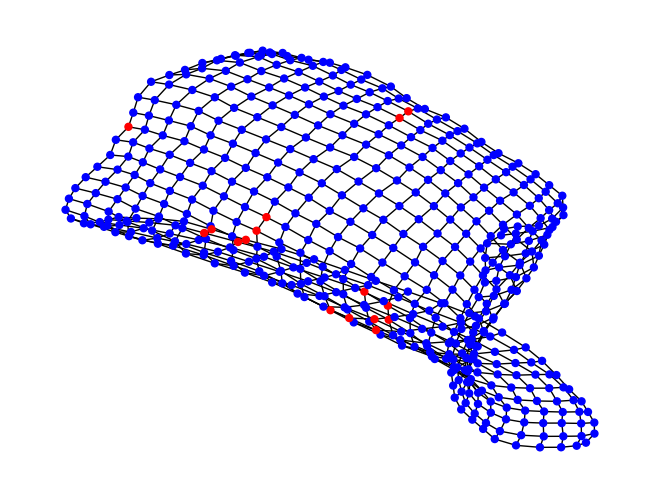

In [ ]:
neuron_abstraction_I(G, background_excitation=0.01, neighbouring_excitation=0.5, activation_timer=5, refractory_stopclock=3)

This shows the first static & very abstracted model that is subject to changes in background excitation, neighbouring excitation, how long cells are active and how long cells are refractory.

Yet, how can I quanitfy data from this in order to come to a good conclusion about these results?

- The model must be visibly dynamical and so moving onto `Thonny` may be necessary to show these real-time effects
- I could explore network analysis to see how at different stages in the cycle there is an increased likelihood of the synchronisation of neuronal firing
- Maybe this could help in more clearly defining to me what is actually means for neuronal firing to be *synchronous* in the first place?
- How easy will be to move to 3D to have a better visualisation of these network patterns?
- What would people in the field actually want (*and when is the best time to reach out*)

**Develop these questions further as the springboards for further research and refine the path I wish to take for this project. If focus is an educational tool then outreach needs to happen yesterday, if exploration into propagation then much more quantifiable tools needs to be explored for this.**

### Updated Models
*Refer to the `gemini` prompt for* **`Research Questions to Guide Exploration` & `More Open-Ended & Unique Research Questions`** *for my progression.*

These are approximately how I wish to progress with this project:

**Small Changes To Existing Model**:
- **Heterogeneity**: rather than there being a uniform weight for each of the nodes, add some randomness to this initialisation (and some noise in the environment for any given interaction to take place - this being a tunable parameter which can be adjusted to make the visualisation of patterns clearer). This aspect in itself will probably take a week to do since I would need to develop a better understanding why this heterogenity is inherent within cells (the citations occurring within this notebook) and also *isolating where these factors derive from*. Here are some initial ideas:
    - E/I balance between each neuron before and after firing (and the probability distribution of activiation). This could be coded by having each of the nodes
    - Need to do more research into the functions of the neurons and these connections to inform how this will work (inhibitory probability should be incorporated for the E/I balance e.g.)

- **Dynamic system**: probably need to put the dynamical system of this in `Thonny` with an updating plot (and maybe Monte Carlo can be learnt so that I can see a large network of this) - this will be fundamental for the open source aspect of this and good to have as an introduction when I publish this to the Discord

- **Classes**: if I want this to collaborative, I need to make my code much much cleaner and using classes is just one simple way of doing that (*I will do from now on though rather than rewrite the above since I will iterate on that below*)

- **Understanding how to publish this**: I will ask Mr Ssemwanga at school (or email him later on) to try to make sure that the licensing on the repo is clean (this will be moved to a different repository) and trying to understand how to make sure this is functional and all good.


**More Existential**:
- **Quantification**:
    - Cluster analysis? What is the size and place of the active nodes? What is this relative to the rest of the nodes and how are they dispersed? Do any patterns emerge - how to even do that computationally?
- **The idea of synchronisation**: What is synchronisation? How could I even measure something that is unclear directly to me - how can this idea be (a) defined and (b) measured? Look at papers for this
- **Many simulations**: What is meaningful about collected data, even if repeated $n$-times with all conditions known? Still don't know what metrics are useful.
- **Adding other factors**: How would you, for example, add a drug to this to test its effect?


One way to quantify some results is having a time series line graph with all the neurons on it, which are oscillating between **on** and **off**: I can isolate under which conditions does a cluster of size $k$ synchronise visually - and what parametres cause these to happen (and how to validate that this was caused by these parametres). Effectively, this would be measuring that the neurons are in phase.

# Questions for today
- Explore how I would add the probabilities aspect (E/I exhitation)


*I am struggling to find aything inherently comprehensive so I will write some contrived pseudocode and then see where it will get me.*



In [ ]:
'''
The chance of activation of a given neuron will be determined by the coding at the edges in the network.
These edges will have a similar nodal {key:value} structure that will hold its probability to it.

The chance of activation is informed by some combination of E/I balance on the edge, the neighbouring activation probability & noise (acting as a mutation for example or some heterogenous quality for each of the edges)
'''


- Explore how to impose heterogeneity with the neurons
*The above is to make it more biologically relevant*
- Reading (and citing here) what the network of neurons in the brainmost abstractedly follow (and why). It will remain in 2D currently for easy data analysis for now but knowing what it actually is will help with this and the explanation in the tool

https://www.sciencedirect.com/science/article/abs/pii/S105381191200941X

**This is effectively what I am trying to make but I cannot access it at all so I might have to ask people in the discord if they have access to it so that it can be cited**

In looking for hypersynchronisation in the brain (https://academic.oup.com/brain/article/142/12/3936/5601465) I found one example of the understanding how hypersynchronicity in the brain emerges since it is important for many neuropathologies. Then I saw that there was a link between seizures (epilepsy as well) to dementia (https://www.alzheimers.org.uk/blog/what-link-between-seizures-and-dementia; https://pmc.ncbi.nlm.nih.gov/articles/PMC9352925/pdf/fneur-13-922535.pdf) it demonstrated a further necessity for these tools since having a somewhat unified model for this could interest reseachers into some topic for this.

Notes on Alzheimers:
Amyloid-$\beta$ plaques in the brain cause an E/I imbalance, this causes neurotoxicity and neuronal death (similar to *status epilepticus*) and is a fascinating unifying point - abstracted models may have a top-down view on things that can help with the collaboraton of topics by other researchers.

All research trying to find and model hypersynchronisation in the brain uses this idea as the precursor to Alzheimer's which is quite fascinating: this precedes the development of the stated amyloid-$\beta$ (A$\beta$) plaques and the gradual disruption of the neural circuitry.

My "theory" is that, as our cells age, there is an increased susceptibility to this syncrhonisation since the mechanism to recognise localised triggers are weakened? Or maybe there is always a likelihood of this occurring but in healthy neurons, this can be regulated easier and the probability is much lower. I need to find sources on this idea and try to link this to the model (and what stage of it this shoudl be integrated within)